In [4]:
import sys
import logging
logging.basicConfig(level=logging.INFO)
from pyrosetta import *
from pyrosetta.teaching import *

#Core Includes
from rosetta.core.kinematics import MoveMap
from rosetta.core.kinematics import FoldTree
from rosetta.core.pack.task import TaskFactory
from rosetta.core.pack.task import operation
from rosetta.core.simple_metrics import metrics
from rosetta.core.select import residue_selector as selections
from rosetta.core import select
from rosetta.core.select.movemap import *

#Protocol Includes
from rosetta.protocols import minimization_packing as pack_min
from rosetta.protocols import relax as rel
from rosetta.protocols.antibody.residue_selector import CDRResidueSelector
from rosetta.protocols.antibody import *
from rosetta.protocols.loops import *

import random
import math
from pyrosetta.rosetta.core.fragment import *
from pyrosetta.rosetta.protocols.simple_moves import ClassicFragmentMover

import matplotlib.pyplot as plt
import numpy as np
init()

INFO:pyrosetta.rosetta:Found rosetta database at: /usr/local/lib/python3.8/dist-packages/pyrosetta-2022.5+release.b3365a12916-py3.8-linux-x86_64.egg/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2022 [Rosetta PyRosetta4.Release.python38.ubuntu 2022.05+release.b3365a12916d9c125d41cdee36639019f73be202 2022-02-03T16:09:08] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
INFO:rosetta:core.init: Checking for fconfig files in pwd and ./rosetta/flags
INFO:rosetta:core.init: Rosetta version: PyRosetta4.Release.python38.ubuntu r310 2022.05+release.b3365a12916 b3365a12916d9c125d41cdee36639019f73be202 http://www.pyrosetta.org 2022-02-03T16:09:08
INFO:rosetta:core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python3.8/dist-packages/pyrosetta-2022.5+release.b3365a12916-py3.8-linux-x86_64.egg/pyrosetta/database
INFO:rosetta:basic.random.init_random_generator: 'RNG d

PyRosetta-4 2022 [Rosetta PyRosetta4.Release.python38.ubuntu 2022.05+release.b3365a12916d9c125d41cdee36639019f73be202 2022-02-03T16:09:08] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [13]:
poses = []
start_pose = pyrosetta.pose_from_pdb("1YY8.clean.pdb")

def landscape():
    KT = 1
    move_map = MoveMap()
    move_map.set_bb(True)
    move_map.set_chi(True)
    move_map.set_jump(True)
    for i in range(0, 200):
        copy_pose = Pose()
        copy_pose.assign(start_pose)
        alter_pose = Pose()
        alter_pose.assign((high_res(copy_pose, move_map, KT)))
        poses.append(alter_pose)
    
    
def high_res_score(your_pose):
    '''create high resolution score function'''
    sfxn =  pyrosetta.get_fa_scorefxn()
    return sfxn(your_pose)

def high_res(your_pose, move_map, KT):
    '''do high res movements/functional equivalent of FastRelax'''
    #full atom (best representation) score function
    sfxn_ssm = pyrosetta.get_fa_scorefxn()
    small_mover = SmallMover(move_map, KT, 1)
    shear_mover = ShearMover(move_map, KT, 1)
    min_mover = MinMover()

    small_mover.angle_max("H", 3)
    small_mover.angle_max("E", 5)
    small_mover.angle_max("L", 6)

    shear_mover.angle_max("H", 3)
    shear_mover.angle_max("E", 5)
    shear_mover.angle_max("L", 6)

    mc_ssm = MonteCarlo(your_pose, sfxn_ssm, KT)
    small_trial = TrialMover(small_mover, mc_ssm)
    shear_trial = TrialMover(shear_mover, mc_ssm)
    min_trial = TrialMover(min_mover, mc_ssm)

    seq_mover = SequenceMover()
    seq_mover.add_mover(small_trial)
    seq_mover.add_mover(shear_trial)
    seq_mover.add_mover(min_trial)

    ssm_tries = 100

    ssm_repeats = RepeatMover(seq_mover, ssm_tries)
    ssm_repeats.apply(your_pose)
    return your_pose
    
rmsds = []
energies = []
landscape()
for i in range(0, len(poses)):
    rmsds.append(pyrosetta.rosetta.core.scoring.CA_rmsd(start_pose, poses[i]))

for i in range(0, len(poses)):
    energies.append(high_res_score(poses[i]))

plt.scatter(rmsds, energies)


INFO:rosetta:core.import_pose.import_pose: File '1YY8.clean.pdb' automatically determined to be of type PDB
INFO:rosetta:core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue ARG 18
INFO:rosetta:core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue ARG 18
INFO:rosetta:core.conformation.Conformation: [ WARNING ] missing heavyatom:  NE  on residue ARG 18
INFO:rosetta:core.conformation.Conformation: [ WARNING ] missing heavyatom:  CZ  on residue ARG 18
INFO:rosetta:core.conformation.Conformation: [ WARNING ] missing heavyatom:  NH1 on residue ARG 18
INFO:rosetta:core.conformation.Conformation: [ WARNING ] missing heavyatom:  NH2 on residue ARG 18
INFO:rosetta:core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLN:NtermProteinFull 214
INFO:rosetta:core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLN:NtermProteinFull 214
INFO:rosetta:core.conformation.Conformation: [ WARNING ] missing

Text(0, 0.5, 'Energy')

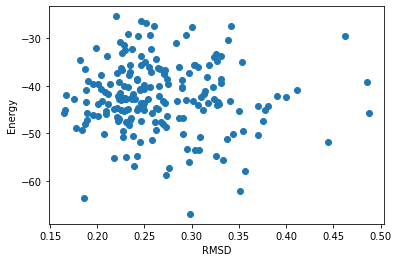

In [12]:
plt.scatter(rmsds, energies)
plt.xlabel("RMSD")
plt.ylabel("Energy")